In [1]:
import gym
import gym_anytrading

In [2]:
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf

Init Plugin
Init Graph Optimizer
Init Kernel


In [3]:
from sb3_contrib import RecurrentPPO

In [4]:
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C, PPO

In [5]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import datetime as dt
from pandas_datareader import data as pdr
import pandas_ta as ta

# Basic Version

In [102]:
stock = pdr.get_data_yahoo('AMZN')

In [103]:
env = gym.make('stocks-v0', df=stock, frame_bound=(5,100), window_size=5)

info {'total_reward': 16.473011016845703, 'total_profit': 0.933738588786026, 'position': 0}


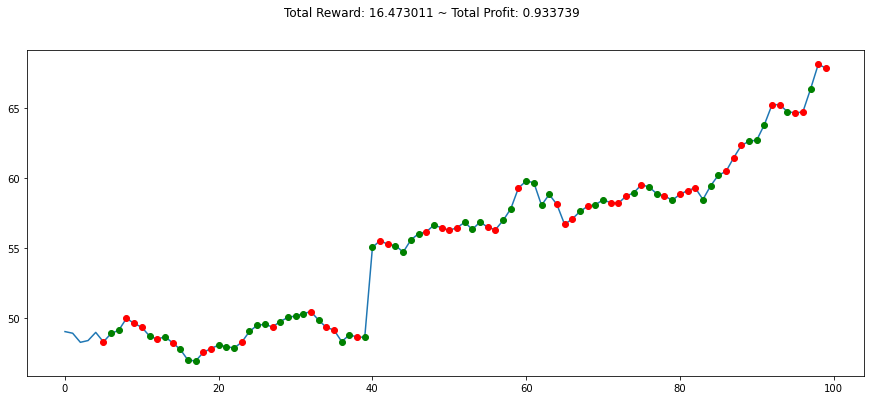

In [104]:
state = env.reset()
while True: 
    action = env.action_space.sample()
    n_state, reward, done, info = env.step(action)
    if done: 
        print("info", info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

In [105]:
env_maker = lambda: gym.make('stocks-v0', df=stock, frame_bound=(5,100), window_size=5)
env = DummyVecEnv([env_maker])

In [106]:
model = RecurrentPPO('MlpLstmPolicy', env, verbose=1) 
model.learn(total_timesteps=100000)

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 2276 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 128  |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 309          |
|    iterations           | 2            |
|    time_elapsed         | 0            |
|    total_timesteps      | 256          |
| train/                  |              |
|    approx_kl            | 0.0026757559 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.692       |
|    explained_variance   | 0.00309      |
|    learning_rate        | 0.0003       |
|    loss                 | 1.04         |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00228     |
|    value_loss           | 2.3          |
------------------------------------------

In [109]:
env = gym.make('stocks-v0', df=stock, frame_bound=(50,100), window_size=5)
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print('Total profit is', info['total_profit'])
        break

Total profit is 0.9857542178788512


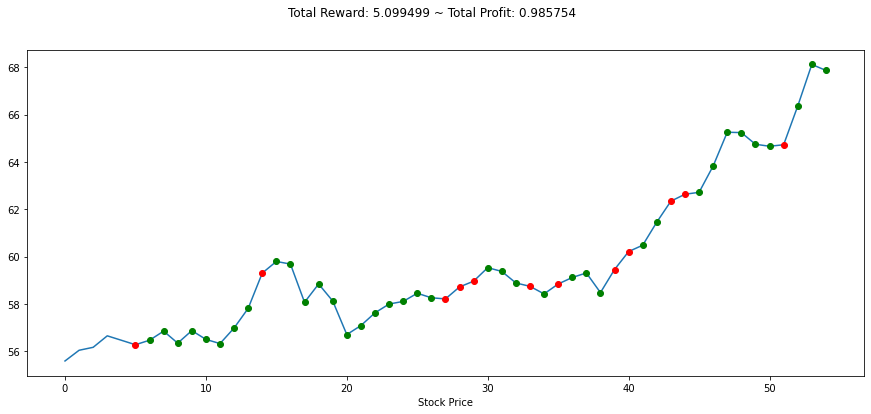

In [110]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.xlabel('Days')
plt.xlabel('Stock Price')
plt.show()

# Custom Indicators

In [112]:
from gym_anytrading.envs import StocksEnv

In [113]:
stock['rsi'] = ta.rsi(pdr.get_data_yahoo('AMZN')['Close'])
stock['sma'] = ta.sma(stock['Close'], 12)
stock['bbl'] = ta.bbands(stock['Close'], length=20, std=2)['BBL_20_2.0']
stock['bbm'] = ta.bbands(stock['Close'], length=20, std=2)['BBM_20_2.0']
stock['bbu'] = ta.bbands(stock['Close'], length=20, std=2)['BBU_20_2.0']

In [114]:
stock.fillna(0, inplace=True)

In [115]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Close'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Close', 'Volume','sma', 'rsi', 'bbl', 'bbm', 'bbu']].to_numpy()[start:end]
    return prices, signal_features

In [116]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals
    
env2 = MyCustomEnv(df=stock, window_size=5, frame_bound=(5,100))

In [117]:
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

In [118]:
model = RecurrentPPO('MlpLstmPolicy', env, verbose=1) 
model.learn(total_timesteps=100000)

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1855 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 128  |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 284          |
|    iterations           | 2            |
|    time_elapsed         | 0            |
|    total_timesteps      | 256          |
| train/                  |              |
|    approx_kl            | 0.0017222902 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.693       |
|    explained_variance   | 0.24         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.689        |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00243     |
|    value_loss           | 1.8          |
------------------------------------------

In [120]:
env = MyCustomEnv(df=stock, window_size=5, frame_bound=(50,100))
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print('Total profit', info['total_profit'])
        break

Total profit 1.0792851249225346


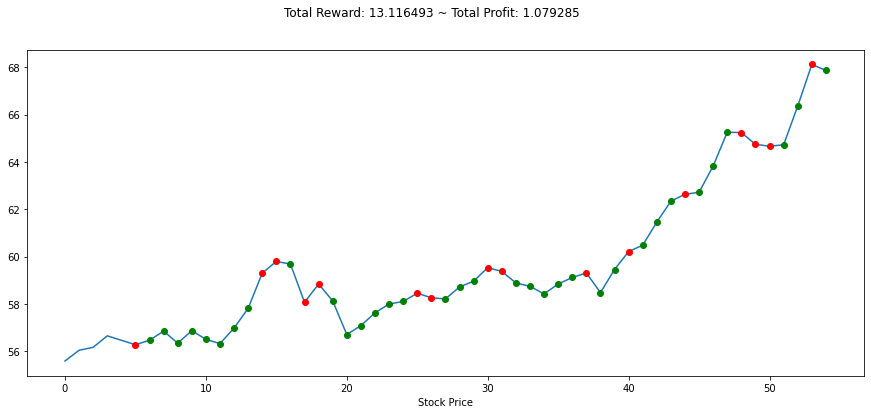

In [121]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.xlabel('Days')
plt.xlabel('Stock Price')
plt.show()